# Using Datasets for Image Loading

This notebook is a tutorial accompying the manuscript "Perspectives: Comparison of Deep Learning Based Segmentation Models on Typical Biophysics and Biomedical Data" by JS Bryan IV, M Tavakoli, and S Presse. In this tutorial, we will learn the basics of using `Dataset` and `DataLoader` classes in PyTorch. We will create our own datasets to load the data referenced in the accompying manuscript.

**Before reading this tutorial, make sure you have properly installed PyTorch and downloaded the data as explained in this repository's README.**

## Introduction

Welcome to this tutorial on PyTorch Datasets! This guide will walk you through the essential concepts of data handling in PyTorch, covering everything from manual data loading to creating custom Dataset classes and integrating them into your training loops using DataLoaders. The specific aim of this tutorial is to explain the datasets used in our accompanying manuscript, which can be found in `data/bdello.py`, `data/neurons.py`, and `data/retinas.py`.

Datasets in PyTorch are crucial for efficient data management and preprocessing, ensuring that your training pipeline is organized and streamlined. By encapsulating the logic needed to access, transform, and augment data, PyTorch Datasets keep your code clean and maintainable, ultimately leading to better performance and accuracy in your machine learning models. DataLoaders complement Datasets by enabling easy batching, shuffling, and loading of data in parallel, further enhancing the efficiency and scalability of your training process.

### Importing Libraries

To get started, we need to import several essential libraries. These libraries will help us handle file paths, load images, and utilize PyTorch functionalities for creating and managing datasets. Here are the libraries we will use:

* os: To handle file paths.
* PIL (Python Imaging Library): To load and manipulate images.
* torch: To access PyTorch functionalities.
* torchvision.transforms: To apply transformations to the images.
* torch.utils.data.Dataset: To create custom datasets.
* torch.utils.data.DataLoader: To manage and load data in batches.
* matplotlib.pyplot: To visualize the images.

Let's import these libraries:

In [1]:
# Import libraries
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

/Users/jbryaniv/Desktop/Projects/BioModelComparison/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data without Datasets

Now that we have imported the necessary libraries, let us start by simply loading images without using PyTorch Datasets. This will help us understand the importance of Datasets and DataLoaders in managing data efficiently. Specifically, let us load the images and masks from the phase-contrast bdellovibrio dataset, which we will refer to as the "bdello" dataset.

The bdello datset is located in the 'data/bdello' directory, which contains two subdirectories: 'images' and 'masks'. The 'images' directory contains the phase-contrast images of bdellovibrio bacteria, while the 'masks' directory contains the corresponding binary masks that segment the bacteria from the background. Each image and mask is named using the same identifier, such as 'img1.png' or 'img2.png'.

In the code below we load the images and masks using `PIL.Image` through `Image.open()`, then convert them to tensors using `torchvision.transforms.ToTensor()`. We then rescale the images using `torch.nn.functional.avg_pool2d()` to reduce their size for visualization purposes and crop the images using standard tensor slicing. Finally we visualize the image and mask using `matplotlib.pyplot`.

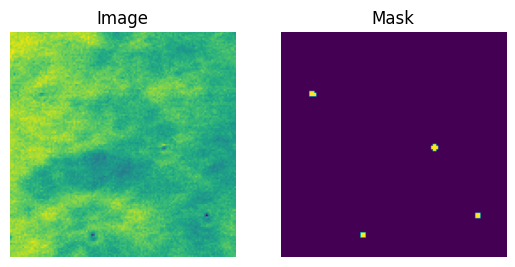

In [2]:
# Set constants
shape = (128, 128)  # Output shape of the image and mask
scale = 4           # Scale factor for the image and mask
row = 0             # Row for cropping the image and mask
col = 0             # Column for cropping the image and mask

# Set paths
base_dir = os.path.dirname(os.getcwd())  # Base directory is one level up from this `tutorials` directory
img_dir = os.path.join(base_dir, 'data/bdello/images')
mask_dir = os.path.join(base_dir, 'data/bdello/masks')
files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

# Load images and masks
file = files[0]  # Get first image file
img = Image.open(os.path.join(img_dir, file))
mask = Image.open(os.path.join(mask_dir, file))

# Convert images and masks to tensors
img = transforms.ToTensor()(img)
mask = transforms.ToTensor()(mask)

# Scale images and masks
img = torch.nn.functional.avg_pool2d(img, scale)
mask = torch.nn.functional.avg_pool2d(mask.float(), scale)

# Convert masks to binary
mask = (mask > 0).long()

# Crop the image and mask
img = img[:, row:row + shape[0], col:col + shape[1]]
mask = mask[:, row:row + shape[0], col:col + shape[1]]

# Visualize the first image and mask
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.numpy().transpose(1, 2, 0))  # Transpose the image tensor to (H, W, C)
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(mask.numpy()[0])  # The mask is a single channel tensor
ax[1].set_title('Mask')
ax[1].axis('off')
plt.show()

In principle, we could use the above code to load images and masks for training a deep learning model. However, this approach requires lots of redundant code and is not scalable or efficient, especially when dealing with large datasets. To address these issues, we will now introduce PyTorch Datasets and DataLoaders, which provide a more organized and streamlined way to manage data in PyTorch.

## Dataset Basics

A Dataset in PyTorch is a class that packages the data and its corresponding labels (if applicable) into a single object. By creating a custom Dataset class, we can define how the data is loaded, transformed, and preprocessed before being fed into the model. This encapsulation of data handling logic makes your code more modular, reusable, and maintainable.

A PyTorch Dataset class must inherit from `torch.utils.data.Dataset` and implement three essential methods: `__init__`, `__len__`, and `__getitem__`. The `__init__` method initializes the dataset by loading the data and setting up any necessary transformations. The `__len__` method returns the total number of samples in the dataset, while the `__getitem__` method loads and returns a sample given its index. By following this structure, we can seamlessly integrate our custom datasets with PyTorch's DataLoader class, which automates the process of batching, shuffling, and loading data in parallel.

In the following code we give an example of a minimal custom Dataset class, where the data is simply the integers from 0 to 9. We define the class and then print some samples.

In [3]:
# Define a minimal working custom dataset
class MyDataset(Dataset):
    def __init__(self):
        self.numbers = list(range(10))  # Create an attribute `numbers` with a list of numbers from 0 to 9

    def __len__(self):
        return len(self.numbers)  # Return the length of the list of numbers when len() is called
    
    def __getitem__(self, idx):
        return self.numbers[idx]  # Return the number at the given index when dataset[idx] is called
    
# Instantiate the custom dataset
dataset = MyDataset()

# Get some examples from the dataset
datalen = len(dataset)
first_example = dataset[0]
second_example = dataset[1]

# Print examples
print(f'Length of dataset: {datalen}')
print(f'First example: {first_example}')
print(f'Second example: {second_example}')

Length of dataset: 10
First example: 0
Second example: 1


As you can see, the Dataset class is very straightforward, consisting of only three main parts. Let us now add some complexity by making the range of numbers a variable upon initialization, and let us return each number and its square as a sample.

In [4]:
# Define slightly more complex custom dataset
class MyDataset(Dataset):
    def __init__(self, number_range):
        self.numbers = list(range(number_range))

    def __len__(self):
        return len(self.numbers)
    
    def __getitem__(self, idx):
        return self.numbers[idx], self.numbers[idx] ** 2
    
# Instantiate the custom dataset
dataset = MyDataset(15)  # Pass the number range as an argument

# Get some examples from the dataset
datalen = len(dataset)
first_example = dataset[0]
second_example = dataset[1]

# Print examples
print(f'Length of dataset: {datalen}')
print(f'First example: {first_example}')
print(f'Second example: {second_example}')

Length of dataset: 15
First example: (0, 0)
Second example: (1, 1)


Notice that the output of `dataset[0]` is a tuple containing the number and its square. This is a common pattern in PyTorch Datasets, where each sample is returned as a tuple or dictionary containing the data and its corresponding label. This structure allows for flexible handling of data and labels, making it easy to adapt the Dataset class to different types of machine learning tasks.

Now that we understand the basics of PyTorch Datasets, let us create a Dataset class for our specific use case.

## Creating a Custom Dataset for the Bdello Dataset

For the bdello dataset, we will create a custom Dataset class that loads the images and masks from the 'data/bdello' directory. The Dataset class will load each image and its corresponding mask, apply transformations to them, and return them as a tuple. We will also include an option to apply additional transformations, such as data augmentation, to the images and masks. When we initialize the dataset, we will specify the scale and cropsize.

Lets set up our `__init__`, `__len__`, and `__getitem__` methods for our class one by one.

### The `__init__` Method

For our `__init__` method, we need to specify the scale and crop size, then load a list of image and mask file paths. We will use the `os` library to list the files in the 'images' and 'masks' directories, and we will sort them to ensure that the images and masks are aligned correctly. We will also define a list of transformations to be applied to the images and masks, including resizing, cropping, and converting to tensors. Then we will save all the necessary attributes for later use.

```python

    def __init__(self, crop=None, scale=1):
        super(BdelloDataset, self).__init__()

        # Set up attributes
        self.crop = crop
        self.scale = scale
        self.base_shape = (1024, 1024)  # Size of the raw images before scaling and cropping

        # Calculate number of crops per image
        if crop is None:
            # If no crop size is specified, use the full image
            self.crops_per_image = 1
        else:
            self.crops_per_image = (
                (self.base_shape[0] // scale // crop[0])
                * (self.base_shape[1] // scale // crop[1])  
            )

        # Set up root directory
        self.root = os.path.join(
            os.path.dirname(os.getcwd()),  # This base directory will be different in the notebook
            'data',
            'bdello'
        )

        # Get files
        self.files = os.listdir(os.path.join(self.root, 'images'))
        self.files = [f for f in self.files if f.endswith('.png')]

```

### The `__len__` Method

For the `__len__` method, we simply return the total number of samples in the dataset. Since each image can be cropped into multiple patches, the total number of samples is the number of images multiplied by the number of crops per image.

```python

    def __len__(self):
        return len(self.files) * self.crops_per_image

```

### The `__getitem__` Method

For the `__getitem__` method, we need to load an image and its corresponding mask given an index. We will first calculate the image index and the crop index within the image. Then we will load the image and mask using the file paths, apply the transformations, and return them as a tuple, just as we showed in the `Loading Data without Datasets` section.

```python
    
    def __getitem__(self, idx):

        # Get file ID and crop ID
        file_id = idx // self.crops_per_image
        crop_id = idx % self.crops_per_image

        # Get image amd mask
        file = self.files[file_id]
        image = Image.open(os.path.join(self.root, 'images', file))
        image = transforms.ToTensor()(image)
        mask = Image.open(os.path.join(self.root, 'masks', file))
        mask = transforms.ToTensor()(mask)

        # Scale
        scale = self.scale
        image = torch.nn.functional.avg_pool2d(image, scale)
        mask = torch.nn.functional.avg_pool2d(mask, scale)

        # Configure mask
        mask = mask[0, :, :] > 0
        mask = mask.long()

        # Crop
        crop = self.crop
        img_shape = image.shape[1:]
        if crop is not None:
            row = crop_id // (img_shape[1] // crop[1])
            col = crop_id % (img_shape[1] // crop[1])
            image = image[:, row*crop[0]:(row+1)*crop[0], col*crop[1]:(col+1)*crop[1]]
            mask = mask[row*crop[0]:(row+1)*crop[0], col*crop[1]:(col+1)*crop[1]]

        # Return
        return image, mask

```

### Putting it All Together

Now that we have defined the `__init__`, `__len__`, and `__getitem__` methods, we can create an instance of our custom Dataset class and access the data using indexing. Let's create an instance of the BdelloDataset class with a scale of 4 and a crop size of 128x128, then access the first sample in the dataset.

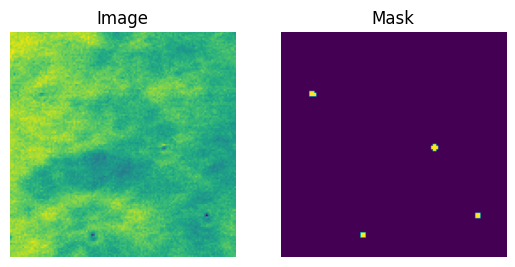

In [5]:

# Create a Bdellobibrio datset class
class BdelloDataset(Dataset):
    def __init__(self, crop=None, scale=1):
        super(BdelloDataset, self).__init__()

        # Set up attributes
        self.crop = crop
        self.scale = scale
        self.base_shape = (1024, 1024)

        # Calculate constants
        if crop is None:
            self.crops_per_image = 1
        else:
            self.crops_per_image = (
                (self.base_shape[0] // scale // crop[0])
                * (self.base_shape[1] // scale // crop[1])  
            )

        # Set up root directory
        self.root = os.path.join(
            os.path.dirname(os.getcwd()),  # This base directory will be different in the notebook
            'data',
            'bdello'
        )

        # Get files
        self.files = os.listdir(os.path.join(self.root, 'images'))
        self.files = [f for f in self.files if f.endswith('.png')]

    def __len__(self):
        return len(self.files) * self.crops_per_image
    
    def __getitem__(self, idx):

        # Get file ID and crop ID
        file_id = idx // self.crops_per_image
        crop_id = idx % self.crops_per_image

        # Get image amd mask
        file = self.files[file_id]
        image = Image.open(os.path.join(self.root, 'images', file))
        image = transforms.ToTensor()(image)
        mask = Image.open(os.path.join(self.root, 'masks', file))
        mask = transforms.ToTensor()(mask)

        # Scale
        scale = self.scale
        image = torch.nn.functional.avg_pool2d(image, scale)
        mask = torch.nn.functional.avg_pool2d(mask, scale)

        # Configure mask
        mask = mask[0, :, :] > 0
        mask = mask.long()

        # Crop
        crop = self.crop
        img_shape = image.shape[1:]
        if crop is not None:
            row = crop_id // (img_shape[1] // crop[1])
            col = crop_id % (img_shape[1] // crop[1])
            image = image[:, row*crop[0]:(row+1)*crop[0], col*crop[1]:(col+1)*crop[1]]
            mask = mask[row*crop[0]:(row+1)*crop[0], col*crop[1]:(col+1)*crop[1]]

        # Return
        return image, mask

# Create a dataset object
dataset = BdelloDataset(crop=(128, 128), scale=4)

# Get item
img, mask = dataset[0]

# Show first image and mask
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.numpy().transpose(1, 2, 0))  # Transpose the image tensor to (H, W, C)
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(mask.numpy())  # The mask is a single channel tensor
ax[1].set_title('Mask')
ax[1].axis('off')
plt.show()

## Using DataLoaders

The final step in our data handling process is to create a DataLoader object that will manage the loading, batching, and shuffling of data from our custom Dataset. The DataLoader class in PyTorch is a powerful tool that automates the process of feeding data into the model, making it easy to iterate over the dataset in batches and shuffle the data for better generalization.

To make a DataLoader, we simply pass our custom Dataset object to the DataLoader class, along with the batch size and any additional arguments we want to specify. We can also set the `shuffle` parameter to True to shuffle the data at the beginning of each epoch. Let's create a DataLoader object for our BdelloDataset with a batch size of 4 and shuffle the data.

In [6]:
# Create a DataLoader
bdello_dataloader = DataLoader(dataset=dataset, batch_size=8, shuffle=True)

# Iterate through the DataLoader
for images, masks in bdello_dataloader:
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    break  # Just to show the first batch, remove this in actual training

Images shape: torch.Size([8, 1, 128, 128])
Masks shape: torch.Size([8, 128, 128])


DataLoaders have additional functionalities that can be useful for training deep learning models, such as parallel data loading using multiple workers and automatic padding of samples in each batch. By using DataLoaders in conjunction with custom Datasets, we can create an efficient and scalable data pipeline that seamlessly integrates with PyTorch's training loop.

## Conclusion

In this tutorial, we have covered the basics of PyTorch Datasets and DataLoaders, demonstrating how to create custom Dataset classes for loading and preprocessing data. By encapsulating the data handling logic in a Dataset class, we can organize and streamline the data loading process, making our code more modular and maintainable. DataLoaders complement Datasets by automating the process of batching, shuffling, and loading data in parallel, enhancing the efficiency and scalability of our training pipeline.